## Train a sparse semantic unet on Vessels gray scale image 

Imports:  Note on Linux for some reason we have to import and show Napari before importing PyTorch. 

In [1]:
import napari
viewer = napari.Viewer()


from tnia.deeplearning.dl_helper import quantile_normalization
import numpy as np
import torch

from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from semantic_dataset import SemanticDataset
import random
from unet import *
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
from semantic_helper import train3
from monai.networks.nets import BasicUNet
from pathlib import Path
import os

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist


/home/bnorthan/mambaforge/envs/easy_augment_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.5 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## Check if Cuda is present

If cuda is not present training will be slow... 

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set Parent Path

This is the path that contains the images we will work with and pre-existing patches that would have been created in notebook ```33_label_semantic_sparse_rgb```

In [3]:

tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2025_03_19_vessel_3D_lightsheet3"

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Collect training data

Collect the training data that would have been created in ```33_label_semantic_sparse_rgb.ipynb```

In [4]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1840.55it/s]

Number of input images 100
Number of ground truth images  100
Size of first input image (256, 256)
Size of first ground truth image  (256, 256)


In [5]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))

Number of training images 98
Number of validaiton images  2


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_test = X_val
Y_test = Y_val

X_train.shape, Y_train.shape

((98, 256, 256), (98, 256, 256))

In [7]:
Y_train.min(), Y_train.max()

(0, 1)

## Preview Training Data

Just make sure it looks right and labels correspond to objects properly

uint16
(256, 256) (256, 256)
0.0 1.0
float32 (256, 256) 0.0 1.0


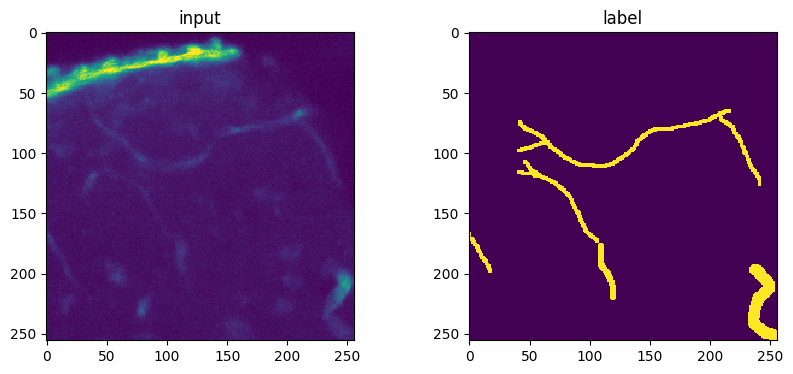

In [8]:
n=25
X_ = X_train[n]
Y_ = Y_train[n]
print(Y_.dtype)

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create Datasets

In [9]:
train_dataset = SemanticDataset(X_train, Y_train, crop_size=256)
test_dataset = SemanticDataset(X_val, Y_val, crop_size=256)
val_dataset = SemanticDataset(X_val, Y_val, crop_size=256)

# verify that the dataset is working
raw, mask = train_dataset[random.randrange(len(train_dataset))]
raw = np.transpose(raw, (1,2,0))
raw.shape,mask.shape

((256, 256, 1), (1, 256, 256))

## Visualize a few datasets

0 1
0 1
0 1


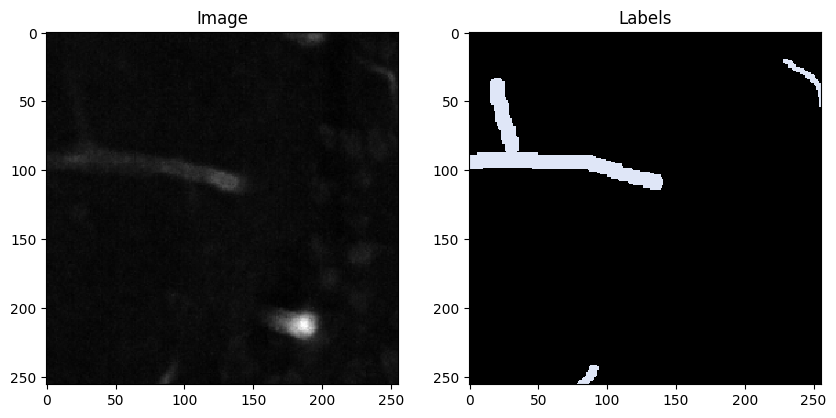

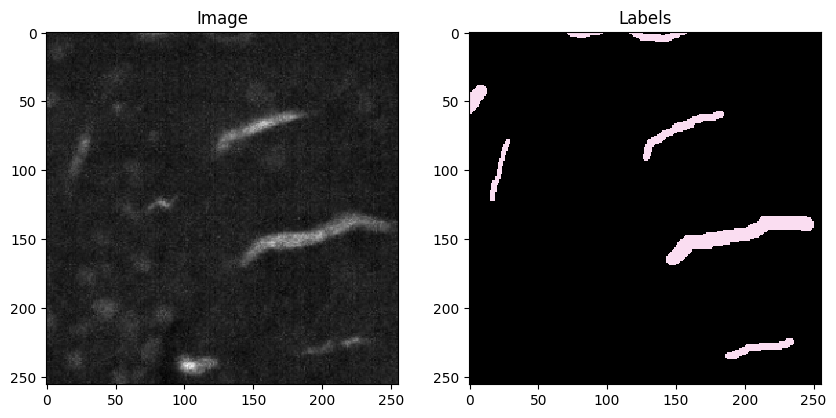

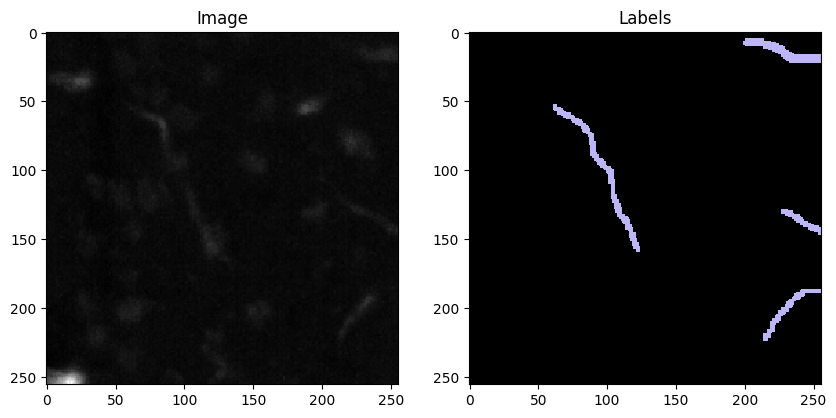

In [10]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[10]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

## Set up unet

We use monai BasicUnet.

Since image is RGB in_channels are 3

Since the dataset we are working with has 3 classes, out_channels are 3

No activation function since we are using CrossEntropyLoss which applies softmax
Note: predictor will need to use a softmax activation function



In [11]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
dtype = torch.LongTensor

net = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    #features=[16, 16, 32, 64, 128, 16],
    act=None,
    #norm="batch",
    #norm=None,
    #dropout=0.25,
)

#net = torch.load( Path(model_path) / 'model_march22.pth')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Start training process

In [13]:
train_batch_size =32 
test_batch_size = 1

learning_rate = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 500

train3(train_loader, val_loader, net, loss_fn, optimizer, dtype, 150, device)
#test_data_loader(train_loader, val_loader, net2, loss_fn, optimizer, dtype, 1, 100, device, writer)
#train(train_loader, val_loader, net2, loss_fn, None, optimizer, dtype, 10, device, writer)
#

Epoch 0: 100%|██████████| 98/98 [00:00<00:00, 127.00it/s]


training loss at epoch 0 is 0.025322788832138995


Epoch 1: 100%|██████████| 98/98 [00:00<00:00, 129.56it/s]


training loss at epoch 1 is 0.02490493046994112


Epoch 2: 100%|██████████| 98/98 [00:00<00:00, 130.09it/s]


training loss at epoch 2 is 0.024368910156950658


Epoch 3: 100%|██████████| 98/98 [00:00<00:00, 130.11it/s]


training loss at epoch 3 is 0.024006995011349112


Epoch 4: 100%|██████████| 98/98 [00:00<00:00, 128.79it/s]


training loss at epoch 4 is 0.023605204966603493


Epoch 5: 100%|██████████| 98/98 [00:00<00:00, 129.21it/s]


training loss at epoch 5 is 0.023312324772075732


Epoch 6: 100%|██████████| 98/98 [00:00<00:00, 129.70it/s]


training loss at epoch 6 is 0.02294228818951821


Epoch 7: 100%|██████████| 98/98 [00:00<00:00, 129.31it/s]


training loss at epoch 7 is 0.022799878704304596


Epoch 8: 100%|██████████| 98/98 [00:00<00:00, 129.81it/s]


training loss at epoch 8 is 0.022412502644013385


Epoch 9: 100%|██████████| 98/98 [00:00<00:00, 129.11it/s]


training loss at epoch 9 is 0.021950802632740567


Epoch 10: 100%|██████████| 98/98 [00:00<00:00, 129.18it/s]


training loss at epoch 10 is 0.02167610976160789


Epoch 11: 100%|██████████| 98/98 [00:00<00:00, 129.28it/s]


training loss at epoch 11 is 0.02125536118234907


Epoch 12: 100%|██████████| 98/98 [00:00<00:00, 129.89it/s]


training loss at epoch 12 is 0.020947202736017655


Epoch 13: 100%|██████████| 98/98 [00:00<00:00, 128.49it/s]


training loss at epoch 13 is 0.02066850479768247


Epoch 14: 100%|██████████| 98/98 [00:00<00:00, 129.21it/s]


training loss at epoch 14 is 0.020394016589437212


Epoch 15: 100%|██████████| 98/98 [00:00<00:00, 129.97it/s]


training loss at epoch 15 is 0.019796794166370313


Epoch 16: 100%|██████████| 98/98 [00:00<00:00, 129.13it/s]


training loss at epoch 16 is 0.019531488722684433


Epoch 17: 100%|██████████| 98/98 [00:00<00:00, 127.88it/s]


training loss at epoch 17 is 0.01923611516855201


Epoch 18: 100%|██████████| 98/98 [00:00<00:00, 128.98it/s]


training loss at epoch 18 is 0.018705455928432698


Epoch 19: 100%|██████████| 98/98 [00:00<00:00, 128.96it/s]


training loss at epoch 19 is 0.01848089482103075


Epoch 20: 100%|██████████| 98/98 [00:00<00:00, 127.80it/s]


training loss at epoch 20 is 0.018164673325966815


Epoch 21: 100%|██████████| 98/98 [00:00<00:00, 128.87it/s]


training loss at epoch 21 is 0.01772796317022674


Epoch 22: 100%|██████████| 98/98 [00:00<00:00, 128.05it/s]


training loss at epoch 22 is 0.0173802984004118


Epoch 23: 100%|██████████| 98/98 [00:00<00:00, 128.74it/s]


training loss at epoch 23 is 0.0168760142156056


Epoch 24: 100%|██████████| 98/98 [00:00<00:00, 127.73it/s]


training loss at epoch 24 is 0.01669540210646026


Epoch 25: 100%|██████████| 98/98 [00:00<00:00, 128.35it/s]


training loss at epoch 25 is 0.01633968219465139


Epoch 26: 100%|██████████| 98/98 [00:00<00:00, 128.91it/s]


training loss at epoch 26 is 0.01583252543089341


Epoch 27: 100%|██████████| 98/98 [00:00<00:00, 127.20it/s]


training loss at epoch 27 is 0.01558463549127384


Epoch 28: 100%|██████████| 98/98 [00:00<00:00, 127.88it/s]


training loss at epoch 28 is 0.015141088135388434


Epoch 29: 100%|██████████| 98/98 [00:00<00:00, 127.57it/s]


training loss at epoch 29 is 0.014876226685485062


Epoch 30: 100%|██████████| 98/98 [00:00<00:00, 128.19it/s]


training loss at epoch 30 is 0.014518460448907346


Epoch 31: 100%|██████████| 98/98 [00:00<00:00, 128.62it/s]


training loss at epoch 31 is 0.014352275096640294


Epoch 32: 100%|██████████| 98/98 [00:00<00:00, 126.95it/s]


training loss at epoch 32 is 0.01398182553904397


Epoch 33: 100%|██████████| 98/98 [00:00<00:00, 128.90it/s]


training loss at epoch 33 is 0.013588686682740036


Epoch 34: 100%|██████████| 98/98 [00:00<00:00, 128.38it/s]


training loss at epoch 34 is 0.01336038234282513


Epoch 35: 100%|██████████| 98/98 [00:00<00:00, 127.77it/s]


training loss at epoch 35 is 0.01293276037488665


Epoch 36: 100%|██████████| 98/98 [00:00<00:00, 129.28it/s]


training loss at epoch 36 is 0.012608768076312785


Epoch 37: 100%|██████████| 98/98 [00:00<00:00, 127.51it/s]


training loss at epoch 37 is 0.012404568037208246


Epoch 38: 100%|██████████| 98/98 [00:00<00:00, 128.29it/s]


training loss at epoch 38 is 0.011983616011483329


Epoch 39: 100%|██████████| 98/98 [00:00<00:00, 128.41it/s]


training loss at epoch 39 is 0.011741474574925949


Epoch 40: 100%|██████████| 98/98 [00:00<00:00, 128.88it/s]


training loss at epoch 40 is 0.011392965304608248


Epoch 41: 100%|██████████| 98/98 [00:00<00:00, 128.10it/s]


training loss at epoch 41 is 0.01124880173984839


Epoch 42: 100%|██████████| 98/98 [00:00<00:00, 127.26it/s]


training loss at epoch 42 is 0.010874637535640172


Epoch 43: 100%|██████████| 98/98 [00:00<00:00, 127.96it/s]


training loss at epoch 43 is 0.010578117504411814


Epoch 44: 100%|██████████| 98/98 [00:00<00:00, 127.42it/s]


training loss at epoch 44 is 0.010385930234072159


Epoch 45: 100%|██████████| 98/98 [00:00<00:00, 127.14it/s]


training loss at epoch 45 is 0.010001292034071319


Epoch 46: 100%|██████████| 98/98 [00:00<00:00, 128.03it/s]


training loss at epoch 46 is 0.009750385217520655


Epoch 47: 100%|██████████| 98/98 [00:00<00:00, 126.81it/s]


training loss at epoch 47 is 0.009552514522659535


Epoch 48: 100%|██████████| 98/98 [00:00<00:00, 127.31it/s]


training loss at epoch 48 is 0.009251375587619081


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 127.00it/s]


training loss at epoch 49 is 0.009170184786222418


Epoch 50: 100%|██████████| 98/98 [00:00<00:00, 127.95it/s]


training loss at epoch 50 is 0.008802171416428625


Epoch 51: 100%|██████████| 98/98 [00:00<00:00, 127.45it/s]


training loss at epoch 51 is 0.00847730101371298


Epoch 52: 100%|██████████| 98/98 [00:00<00:00, 127.19it/s]


training loss at epoch 52 is 0.008536351122418228


Epoch 53: 100%|██████████| 98/98 [00:00<00:00, 128.10it/s]


training loss at epoch 53 is 0.00825012231967887


Epoch 54: 100%|██████████| 98/98 [00:00<00:00, 127.85it/s]


training loss at epoch 54 is 0.00810938723841492


Epoch 55: 100%|██████████| 98/98 [00:00<00:00, 126.73it/s]


training loss at epoch 55 is 0.00787612506929709


Epoch 56: 100%|██████████| 98/98 [00:00<00:00, 126.94it/s]


training loss at epoch 56 is 0.00775840696023435


Epoch 57: 100%|██████████| 98/98 [00:00<00:00, 127.26it/s]


training loss at epoch 57 is 0.007501443581921714


Epoch 58: 100%|██████████| 98/98 [00:00<00:00, 127.27it/s]


training loss at epoch 58 is 0.007320083677768707


Epoch 59: 100%|██████████| 98/98 [00:00<00:00, 126.74it/s]


training loss at epoch 59 is 0.007109334882424802


Epoch 60: 100%|██████████| 98/98 [00:00<00:00, 128.05it/s]


training loss at epoch 60 is 0.0068566914723843944


Epoch 61: 100%|██████████| 98/98 [00:00<00:00, 126.54it/s]


training loss at epoch 61 is 0.006752211828621066


Epoch 62: 100%|██████████| 98/98 [00:00<00:00, 127.75it/s]


training loss at epoch 62 is 0.006675745911744176


Epoch 63: 100%|██████████| 98/98 [00:00<00:00, 126.94it/s]


training loss at epoch 63 is 0.006558996530211702


Epoch 64: 100%|██████████| 98/98 [00:00<00:00, 127.61it/s]


training loss at epoch 64 is 0.006324716520552732


Epoch 65: 100%|██████████| 98/98 [00:00<00:00, 127.15it/s]


training loss at epoch 65 is 0.00617640419882171


Epoch 66: 100%|██████████| 98/98 [00:00<00:00, 127.06it/s]


training loss at epoch 66 is 0.005958833712704328


Epoch 67: 100%|██████████| 98/98 [00:00<00:00, 127.27it/s]


training loss at epoch 67 is 0.005860906170339001


Epoch 68: 100%|██████████| 98/98 [00:00<00:00, 127.58it/s]


training loss at epoch 68 is 0.005746985272485383


Epoch 69: 100%|██████████| 98/98 [00:00<00:00, 127.57it/s]


training loss at epoch 69 is 0.005670192138272889


Epoch 70: 100%|██████████| 98/98 [00:00<00:00, 126.85it/s]


training loss at epoch 70 is 0.005502395331859589


Epoch 71: 100%|██████████| 98/98 [00:00<00:00, 127.39it/s]


training loss at epoch 71 is 0.005374491670910193


Epoch 72: 100%|██████████| 98/98 [00:00<00:00, 127.20it/s]


training loss at epoch 72 is 0.005140298863454741


Epoch 73: 100%|██████████| 98/98 [00:00<00:00, 127.03it/s]


training loss at epoch 73 is 0.005179283722322814


Epoch 74: 100%|██████████| 98/98 [00:00<00:00, 127.42it/s]


training loss at epoch 74 is 0.005123048260503886


Epoch 75: 100%|██████████| 98/98 [00:00<00:00, 127.46it/s]


training loss at epoch 75 is 0.004896826205813155


Epoch 76: 100%|██████████| 98/98 [00:00<00:00, 128.03it/s]


training loss at epoch 76 is 0.00475186930627239


Epoch 77: 100%|██████████| 98/98 [00:00<00:00, 124.40it/s]


training loss at epoch 77 is 0.004652565003049617


Epoch 78: 100%|██████████| 98/98 [00:00<00:00, 127.93it/s]


training loss at epoch 78 is 0.004534899428182719


Epoch 79: 100%|██████████| 98/98 [00:00<00:00, 126.66it/s]


training loss at epoch 79 is 0.004619298540816015


Epoch 80: 100%|██████████| 98/98 [00:00<00:00, 126.95it/s]


training loss at epoch 80 is 0.004427854123772407


Epoch 81: 100%|██████████| 98/98 [00:00<00:00, 126.88it/s]


training loss at epoch 81 is 0.0043158901437204715


Epoch 82: 100%|██████████| 98/98 [00:00<00:00, 127.35it/s]


training loss at epoch 82 is 0.004389387992571811


Epoch 83: 100%|██████████| 98/98 [00:00<00:00, 120.76it/s]


training loss at epoch 83 is 0.004232984264286197


Epoch 84: 100%|██████████| 98/98 [00:00<00:00, 127.51it/s]


training loss at epoch 84 is 0.004263757518967804


Epoch 85: 100%|██████████| 98/98 [00:00<00:00, 126.51it/s]


training loss at epoch 85 is 0.004154684288161141


Epoch 86: 100%|██████████| 98/98 [00:00<00:00, 126.94it/s]


training loss at epoch 86 is 0.004329933727882347


Epoch 87: 100%|██████████| 98/98 [00:00<00:00, 124.95it/s]


training loss at epoch 87 is 0.00417227746576679


Epoch 88: 100%|██████████| 98/98 [00:00<00:00, 126.96it/s]


training loss at epoch 88 is 0.004249033347076299


Epoch 89: 100%|██████████| 98/98 [00:00<00:00, 125.19it/s]


training loss at epoch 89 is 0.004028587925190829


Epoch 90: 100%|██████████| 98/98 [00:00<00:00, 126.57it/s]


training loss at epoch 90 is 0.003888346406878257


Epoch 91: 100%|██████████| 98/98 [00:00<00:00, 120.65it/s]


training loss at epoch 91 is 0.003925405062583028


Epoch 92: 100%|██████████| 98/98 [00:00<00:00, 126.92it/s]


training loss at epoch 92 is 0.0036686014155952297


Epoch 93: 100%|██████████| 98/98 [00:00<00:00, 126.45it/s]


training loss at epoch 93 is 0.00364684564422588


Epoch 94: 100%|██████████| 98/98 [00:00<00:00, 122.66it/s]


training loss at epoch 94 is 0.0035483505652875317


Epoch 95: 100%|██████████| 98/98 [00:00<00:00, 128.52it/s]


training loss at epoch 95 is 0.0036217178769257603


Epoch 96: 100%|██████████| 98/98 [00:00<00:00, 125.83it/s]


training loss at epoch 96 is 0.003482400610738871


Epoch 97: 100%|██████████| 98/98 [00:00<00:00, 126.59it/s]


training loss at epoch 97 is 0.0034368522465229034


Epoch 98: 100%|██████████| 98/98 [00:00<00:00, 126.59it/s]


training loss at epoch 98 is 0.0034279292639420957


Epoch 99: 100%|██████████| 98/98 [00:00<00:00, 127.62it/s]


training loss at epoch 99 is 0.0035072819766949633


Epoch 100: 100%|██████████| 98/98 [00:00<00:00, 122.62it/s]


training loss at epoch 100 is 0.0032420191077553494


Epoch 101: 100%|██████████| 98/98 [00:00<00:00, 127.27it/s]


training loss at epoch 101 is 0.0034083448046324204


Epoch 102: 100%|██████████| 98/98 [00:00<00:00, 123.27it/s]


training loss at epoch 102 is 0.0032246798581006576


Epoch 103: 100%|██████████| 98/98 [00:00<00:00, 125.19it/s]


training loss at epoch 103 is 0.003040475884870607


Epoch 104: 100%|██████████| 98/98 [00:00<00:00, 125.02it/s]


training loss at epoch 104 is 0.003016159166486896


Epoch 105: 100%|██████████| 98/98 [00:00<00:00, 121.38it/s]


training loss at epoch 105 is 0.003049354392046831


Epoch 106: 100%|██████████| 98/98 [00:00<00:00, 124.16it/s]


training loss at epoch 106 is 0.002937899864449793


Epoch 107: 100%|██████████| 98/98 [00:00<00:00, 126.40it/s]


training loss at epoch 107 is 0.0030049669499299966


Epoch 108: 100%|██████████| 98/98 [00:00<00:00, 125.30it/s]


training loss at epoch 108 is 0.002926539781750465


Epoch 109: 100%|██████████| 98/98 [00:00<00:00, 127.41it/s]


training loss at epoch 109 is 0.0028040513244210457


Epoch 110: 100%|██████████| 98/98 [00:00<00:00, 127.11it/s]


training loss at epoch 110 is 0.0029137497197608557


Epoch 111: 100%|██████████| 98/98 [00:00<00:00, 126.75it/s]


training loss at epoch 111 is 0.002818108593322793


Epoch 112: 100%|██████████| 98/98 [00:00<00:00, 123.57it/s]


training loss at epoch 112 is 0.0026676170147803364


Epoch 113: 100%|██████████| 98/98 [00:00<00:00, 125.20it/s]


training loss at epoch 113 is 0.0027032867834276084


Epoch 114: 100%|██████████| 98/98 [00:00<00:00, 127.43it/s]


training loss at epoch 114 is 0.002689632073957093


Epoch 115: 100%|██████████| 98/98 [00:00<00:00, 127.08it/s]


training loss at epoch 115 is 0.0026233364276740017


Epoch 116: 100%|██████████| 98/98 [00:00<00:00, 127.24it/s]


training loss at epoch 116 is 0.0026214535975334595


Epoch 117: 100%|██████████| 98/98 [00:00<00:00, 117.31it/s]


training loss at epoch 117 is 0.002544816203263341


Epoch 118: 100%|██████████| 98/98 [00:00<00:00, 121.04it/s]


training loss at epoch 118 is 0.0026799278827954313


Epoch 119: 100%|██████████| 98/98 [00:00<00:00, 125.26it/s]


training loss at epoch 119 is 0.0025479246539120773


Epoch 120: 100%|██████████| 98/98 [00:00<00:00, 119.10it/s]


training loss at epoch 120 is 0.0024677202561680153


Epoch 121: 100%|██████████| 98/98 [00:00<00:00, 124.82it/s]


training loss at epoch 121 is 0.002337376035901965


Epoch 122: 100%|██████████| 98/98 [00:00<00:00, 124.47it/s]


training loss at epoch 122 is 0.0023885918210963812


Epoch 123: 100%|██████████| 98/98 [00:00<00:00, 121.14it/s]


training loss at epoch 123 is 0.0024832772205070574


Epoch 124: 100%|██████████| 98/98 [00:00<00:00, 119.55it/s]


training loss at epoch 124 is 0.0024168400892189573


Epoch 125: 100%|██████████| 98/98 [00:00<00:00, 123.92it/s]


training loss at epoch 125 is 0.002397434823975271


Epoch 126: 100%|██████████| 98/98 [00:00<00:00, 119.22it/s]


training loss at epoch 126 is 0.002343544394386058


Epoch 127: 100%|██████████| 98/98 [00:00<00:00, 120.82it/s]


training loss at epoch 127 is 0.0025395620614290237


Epoch 128: 100%|██████████| 98/98 [00:00<00:00, 123.79it/s]


training loss at epoch 128 is 0.002375619485974312


Epoch 129: 100%|██████████| 98/98 [00:00<00:00, 124.58it/s]


training loss at epoch 129 is 0.002440918427036733


Epoch 130: 100%|██████████| 98/98 [00:00<00:00, 120.29it/s]


training loss at epoch 130 is 0.002499923033981907


Epoch 131: 100%|██████████| 98/98 [00:00<00:00, 121.90it/s]


training loss at epoch 131 is 0.0025215079741818564


Epoch 132: 100%|██████████| 98/98 [00:00<00:00, 125.72it/s]


training loss at epoch 132 is 0.002385823550272961


Epoch 133: 100%|██████████| 98/98 [00:00<00:00, 121.28it/s]


training loss at epoch 133 is 0.0024406258016824722


Epoch 134: 100%|██████████| 98/98 [00:00<00:00, 121.07it/s]


training loss at epoch 134 is 0.0024129415349084505


Epoch 135: 100%|██████████| 98/98 [00:00<00:00, 123.46it/s]


training loss at epoch 135 is 0.0022219959646463394


Epoch 136: 100%|██████████| 98/98 [00:00<00:00, 121.61it/s]


training loss at epoch 136 is 0.0022364317306450437


Epoch 137: 100%|██████████| 98/98 [00:00<00:00, 121.08it/s]


training loss at epoch 137 is 0.0021314075102611464


Epoch 138: 100%|██████████| 98/98 [00:00<00:00, 126.32it/s]


training loss at epoch 138 is 0.002258474653472706


Epoch 139: 100%|██████████| 98/98 [00:00<00:00, 127.13it/s]


training loss at epoch 139 is 0.0020366619360082


Epoch 140: 100%|██████████| 98/98 [00:00<00:00, 118.77it/s]


training loss at epoch 140 is 0.002075690586043864


Epoch 141: 100%|██████████| 98/98 [00:00<00:00, 119.63it/s]


training loss at epoch 141 is 0.0020369959577005736


Epoch 142: 100%|██████████| 98/98 [00:00<00:00, 120.63it/s]


training loss at epoch 142 is 0.0019264186219293245


Epoch 143: 100%|██████████| 98/98 [00:00<00:00, 121.30it/s]


training loss at epoch 143 is 0.001888598486477015


Epoch 144: 100%|██████████| 98/98 [00:00<00:00, 124.23it/s]


training loss at epoch 144 is 0.001939189791375277


Epoch 145: 100%|██████████| 98/98 [00:00<00:00, 119.56it/s]


training loss at epoch 145 is 0.0018836741468736104


Epoch 146: 100%|██████████| 98/98 [00:00<00:00, 117.29it/s]


training loss at epoch 146 is 0.001901569301072432


Epoch 147: 100%|██████████| 98/98 [00:00<00:00, 123.65it/s]


training loss at epoch 147 is 0.0018478861192659456


Epoch 148: 100%|██████████| 98/98 [00:00<00:00, 122.98it/s]


training loss at epoch 148 is 0.0017663751329694475


Epoch 149: 100%|██████████| 98/98 [00:00<00:00, 127.20it/s]

training loss at epoch 149 is 0.0016611893186155632


## save unet

In [14]:

torch.save(net, Path(model_path) / 'model_march22.pth')

## Test predictions

In [ ]:

import torch.nn.functional as F

rlcm = random_label_cmap()

for i in range(20):
    #features, label = train_loader.dataset[random.randrange(len(train_loader.dataset))]
    features, label = train_loader.dataset[i]
    
    net.eval()
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)       
    #features = features.todevice()
    predicted = net(features_tensor)

    print(predicted.shape, features.shape)

    features = np.transpose(features, (1,2,0))

    predicted.shape
    c1 = predicted[0,0,:,:].cpu().detach().numpy()
    c2 = predicted[0,1,:,:].cpu().detach().numpy()

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(predicted, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)
    
    fig = imshow_multi2d([features, label, c1, c2, predicted_classes], ['Image', 'label', 'Class 1', 'Class 2', 'predicted'], 1, 5, 12, 12,colormaps=['gray', rlcm, 'viridis', 'viridis', rlcm])

NameError: name 'train_loader' is not defined